In [259]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)
par_get_daily_pred
par_get_all_signal
get_signal_stat

<function helper.get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str='2018', reverse=1, tranct=0.00011, max_spread=0.61, tranct_ratio=True, min_pnl=2, min_num=20, atr_filter=0, HEAD_PATH='d:/intern', SIGNAL_PATH='d:/intern')>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1092

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [7]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))
format_dates[test_sample][0]

510
582


Timestamp('2018-01-02 00:00:00')

In [49]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
#y_signal = "ret."+str(period)+".004"
y_signal = "ret."+str(period)

- at first we try using lasso for them together 

In [50]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [51]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape
## (2045, 45)

(2045, 45)

In [78]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:3]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# IF (2045, 49)
# IH (1431, 49)
# IC (2048, 49)



IF (2045, 49)
IH (1431, 49)
IC (2048, 49)


In [91]:
result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

array(['trade.imb.range.4096', 'total.trade.imb.range.4096',
       'ma.dif.10.range.4096', 'trade.imb.std.4096',
       'total.trade.imb.std.4096', 'ma.dif.10.std.4096'], dtype='<U38')

In [146]:
pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]

In [92]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [151]:
#x_train = train_mat.iloc[:, :n_sigl].values
x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
fit_coef[pos] = model.coef_/x_std
print(fit_coef)

# (5524, 11)
# [ 0.          0.          0.          0.          0.         -0.05195899
#   0.          0.          0.          0.09357218 -0.0425371   0.
#   0.          0.         -0.35163503  0.          0.          0.19263128
#  -0.08827555  0.          0.          0.          0.          0.55179563
#  -0.11277601  0.         -0.26074473  0.01137263  0.          0.
#   0.          0.          0.          0.          0.          0.
#   0.          0.          0.          0.          0.          0.
#   0.          0.02213094  0.        ]





(5524, 11)
[ 0.          0.          0.          0.          0.         -0.05195899
  0.          0.          0.          0.09357218 -0.0425371   0.
  0.          0.         -0.35163503  0.          0.          0.19263128
 -0.08827555  0.          0.          0.          0.          0.55179563
 -0.11277601  0.         -0.26074473  0.01137263  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.02213094  0.        ]


In [152]:
coef_list=dict([])
for product in product_list[:3]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# IF
# price.osci.4096                    -0.000587
# trade.imb.range.4096                0.000615
# total.trade.imb.range.4096         -0.000135
# price.osci.range.4096              -0.000140
# kdj.j.range.4096                    0.000077
# trade.imb.std.4096                 -0.002539
# price.osci.std.4096                 0.000895
# ma.dif.10.std.4096                 -0.011869
# kdj.j.std.4096                     -0.000434
# trade.imb.volume.open.ratio.4096    0.022328
# kdj.k.trend.index.4096              0.000336
# dtype: float64
# IH
# price.osci.4096                    -0.000645
# trade.imb.range.4096                0.001381
# total.trade.imb.range.4096         -0.000233
# price.osci.range.4096              -0.000206
# kdj.j.range.4096                    0.000112
# trade.imb.std.4096                 -0.005568
# price.osci.std.4096                 0.001313
# ma.dif.10.std.4096                 -0.016948
# kdj.j.std.4096                     -0.000609
# trade.imb.volume.open.ratio.4096    0.021724
# kdj.k.trend.index.4096              0.000363
# dtype: float64
# IC
# price.osci.4096                    -0.000789
# trade.imb.range.4096                0.000369
# total.trade.imb.range.4096         -0.000077
# price.osci.range.4096              -0.000080
# kdj.j.range.4096                    0.000044
# trade.imb.std.4096                 -0.001353
# price.osci.std.4096                 0.000501
# ma.dif.10.std.4096                 -0.004492
# kdj.j.std.4096                     -0.000236
# trade.imb.volume.open.ratio.4096    0.028255
# kdj.k.trend.index.4096              0.000460
# dtype: float64

IF
price.osci.4096                    -0.000587
trade.imb.range.4096                0.000615
total.trade.imb.range.4096         -0.000135
price.osci.range.4096              -0.000140
kdj.j.range.4096                    0.000077
trade.imb.std.4096                 -0.002539
price.osci.std.4096                 0.000895
ma.dif.10.std.4096                 -0.011869
kdj.j.std.4096                     -0.000434
trade.imb.volume.open.ratio.4096    0.022328
kdj.k.trend.index.4096              0.000336
dtype: float64
IH
price.osci.4096                    -0.000645
trade.imb.range.4096                0.001381
total.trade.imb.range.4096         -0.000233
price.osci.range.4096              -0.000206
kdj.j.range.4096                    0.000112
trade.imb.std.4096                 -0.005568
price.osci.std.4096                 0.001313
ma.dif.10.std.4096                 -0.016948
kdj.j.std.4096                     -0.000609
trade.imb.volume.open.ratio.4096    0.021724
kdj.k.trend.index.4096            

In [153]:
SAVE_PATH = "e:/intern"
#save(coef_list, SAVE_PATH+"/finance.lasso.pkl")
save(coef_list, SAVE_PATH+"/index.lasso.pkl")

In [154]:
#coef_list = load(SAVE_PATH+"/finance.lasso.pkl")
coef_list = load(SAVE_PATH+"/index.lasso.pkl")

In [155]:
strat = "overall.lasso."+str(period)
   
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [157]:
%%time
for product in product_list[0:3]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# IF
# IH
# IC
# Wall time: 22min 26s



IF
IH
IC
Wall time: 22min 26s


In [158]:
%%time
for product in product_list[:3]:
    print(product)
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

# IF
# IH
# IC
# T
# TF
# Wall time: 3min 22s


IF
IH
IC
Wall time: 1min 30s


In [159]:
%%time
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2018", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 3min 41s



reverse=1
reverse=1
reverse=1
Wall time: 7min 16s


IF train sharpe  0.5382723555283818 test sharpe  0.9297478470109406
IH train sharpe  0.3015850553271201 test sharpe  -0.2627275976746257
IC train sharpe  0.5217126788528591 test sharpe  0.8105542278366956
train sharpe:  0.6174139012165428 test sharpe:  0.6998230576278767


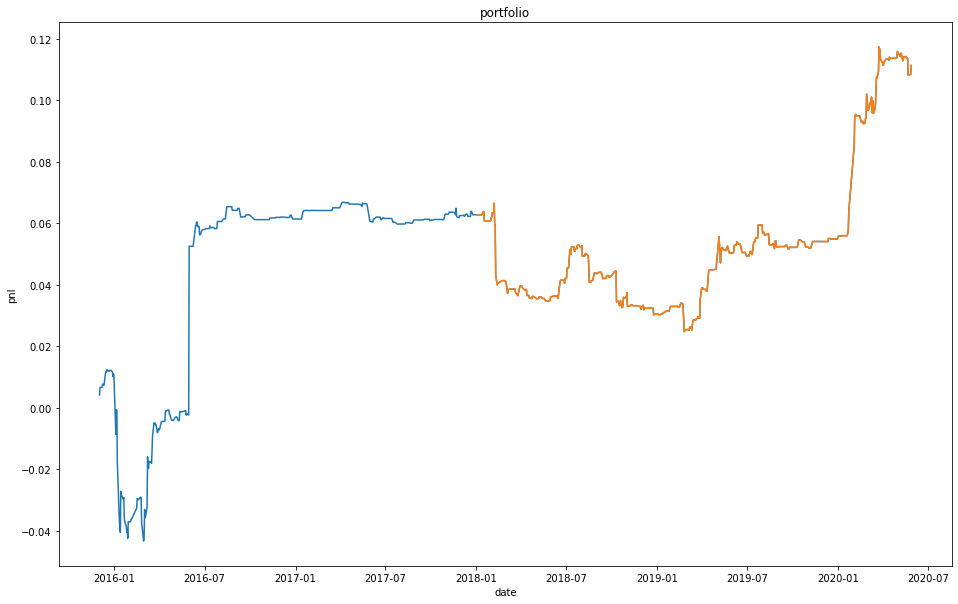

In [160]:
i = 0
strat = "overall.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list[:3]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# IF train sharpe  0.5382723555283818 test sharpe  0.9297478470109406
# IH train sharpe  0.3015850553271201 test sharpe  -0.2627275976746257
# IC train sharpe  0.5217126788528591 test sharpe  0.8105542278366956
# train sharpe:  0.6174139012165428 test sharpe:  0.6998230576278767






- we can see that the result is much better than before
- so we can use this method for rolling models
- However, using the previous method may be too slow
- we calcualte the predictions values of each product using 26 mintues, and other time add up together would be 30 mintues
- if we are rolling on a monthly basis
- from 201801 to 201908 there are 20 months
- so it may use 10 hours for the rolling

- rolling model

- at first we need to know how many ticks every day

In [161]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

- at first we can try a not so intensive method
- we can get the starting day for train

In [162]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV

- at first we can try a not so intensive method
- we can get the starting day for train

In [163]:
from sklearn.preprocessing import StandardScaler

- now we generate prediction values for next 22 days

- now we can combien all these and get a function for rolling
- we can also use calendar month rather than 22 days

In [164]:
month = np.array([file[:6] for file in all_dates])

In [165]:
month_len = np.unique(month, return_counts=True)
month_len

# (array(['201512', '201601', '201602', '201603', '201604', '201605',
#         '201606', '201607', '201608', '201609', '201610', '201611',
#         '201612', '201701', '201702', '201703', '201704', '201705',
#         '201706', '201707', '201708', '201709', '201710', '201711',
#         '201712', '201801', '201802', '201803', '201804', '201805',
#         '201806', '201807', '201808', '201809', '201810', '201811',
#         '201812', '201901', '201902', '201903', '201904', '201905',
#         '201906', '201907', '201908', '201909', '201910', '201911',
#         '201912', '202001', '202002', '202003', '202004', '202005'],
#        dtype='<U6'),
#  array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
#         20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
#         18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20,
#         22, 20, 17], dtype=int64))

(array(['201512', '201601', '201602', '201603', '201604', '201605',
        '201606', '201607', '201608', '201609', '201610', '201611',
        '201612', '201701', '201702', '201703', '201704', '201705',
        '201706', '201707', '201708', '201709', '201710', '201711',
        '201712', '201801', '201802', '201803', '201804', '201805',
        '201806', '201807', '201808', '201809', '201810', '201811',
        '201812', '201901', '201902', '201903', '201904', '201905',
        '201906', '201907', '201908', '201909', '201910', '201911',
        '201912', '202001', '202002', '202003', '202004', '202005'],
       dtype='<U6'),
 array([22, 20, 16, 23, 20, 21, 20, 21, 23, 20, 16, 22, 22, 18, 18, 23, 18,
        20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22, 20, 22, 23, 19,
        18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20,
        22, 20, 17], dtype=int64))

In [179]:
train_tick_start = dict([]) ## startting ticks of training set
train_tick_end = dict([])   ## ending ticks of training set
cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
train_mat = np.zeros((0,n_signal))
y_train = np.array([])
for product in product_list[:3]: ## combine data sets together and then fit the model
    cum_daily_ticks[product] = daily_ticks[product].cumsum()
    train_tick_start[product] = 0
    train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
    x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
    cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
    scaler.fit(x_train)
    x_train = scaler.transform(x_train) ## normalize data before combine
    train_std_mat[product] = np.sqrt(scaler.var_)
    train_mat = np.append(train_mat,x_train, axis=0)
    y_train = np.append(y_train, cur_y_train)

In [188]:
train_mat = pd.DataFrame(train_mat, columns=signal_list)
train

In [192]:
train_mat[y_signal] = y_train
result = forward_selected(train_mat, y_signal)
pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]

In [195]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    train_mat = pd.DataFrame(train_mat, columns=signal_list)
    train_mat[y_signal] = y_train
    result = forward_selected(train_mat, y_signal)
    x_train = train_mat[result["chosen.signals"]]
    pos = [np.where(signal_list==x)[0][0] for x in result["chosen.signals"]]
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = np.zeros(n_signal)
    fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [196]:
test_range = np.where(month_len[0] > "2018" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

# ['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
#  '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
#  '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
#  '202001' '202002']



['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
 '202001' '202002' '202003' '202004' '202005']


In [197]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.lasso.4096" ## with double normalization
#y_signal = "ret.4096.004"
y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          [], product_list[:3], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1
    
# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# 51 202003
# 52 202004
# 53 202005
# Wall time: 19min 49s

25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
Wall time: 19min 49s


- Then we can generate prediction values of each model

In [198]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list[0:3]:
        coef = coef_list[product]
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
        parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                  product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# 51 202003
# 52 202004
# 53 202005
# Wall time: 1h 7min


25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
Wall time: 1h 7min


In [201]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.lasso.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    ## we only generte distribution on training set, not on test set
    for product in product_list[:3]:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201801 20151202.pkl 20171229.pkl
# 201802 20160104.pkl 20180131.pkl
# 201803 20160201.pkl 20180228.pkl
# 201804 20160301.pkl 20180330.pkl
# 201805 20160401.pkl 20180427.pkl
# 201806 20160503.pkl 20180531.pkl
# 201807 20160601.pkl 20180629.pkl
# 201808 20160701.pkl 20180731.pkl
# 201809 20160801.pkl 20180831.pkl
# 201810 20160901.pkl 20180928.pkl
# 201811 20161010.pkl 20181031.pkl
# 201812 20161101.pkl 20181130.pkl
# 201901 20161201.pkl 20181228.pkl
# 201902 20170103.pkl 20190131.pkl
# 201903 20170203.pkl 20190228.pkl
# 201904 20170301.pkl 20190329.pkl
# 201905 20170405.pkl 20190430.pkl
# 201906 20170502.pkl 20190531.pkl
# 201907 20170601.pkl 20190628.pkl
# 201908 20170703.pkl 20190731.pkl
# 201909 20170801.pkl 20190830.pkl
# 201910 20170901.pkl 20190930.pkl
# 201911 20171009.pkl 20191031.pkl
# 201912 20171101.pkl 20191129.pkl
# 202001 20171201.pkl 20191231.pkl
# 202002 20180102.pkl 20200123.pkl
# 202003 20180201.pkl 20200228.pkl
# 202004 20180301.pkl 20200331.pkl
# 202005 20180402.pkl 20200430.pkl
# Wall time: 18min 13s

201801 20151202.pkl 20171229.pkl
201802 20160104.pkl 20180131.pkl
201803 20160201.pkl 20180228.pkl
201804 20160301.pkl 20180330.pkl
201805 20160401.pkl 20180427.pkl
201806 20160503.pkl 20180531.pkl
201807 20160601.pkl 20180629.pkl
201808 20160701.pkl 20180731.pkl
201809 20160801.pkl 20180831.pkl
201810 20160901.pkl 20180928.pkl
201811 20161010.pkl 20181031.pkl
201812 20161101.pkl 20181130.pkl
201901 20161201.pkl 20181228.pkl
201902 20170103.pkl 20190131.pkl
201903 20170203.pkl 20190228.pkl
201904 20170301.pkl 20190329.pkl
201905 20170405.pkl 20190430.pkl
201906 20170502.pkl 20190531.pkl
201907 20170601.pkl 20190628.pkl
201908 20170703.pkl 20190731.pkl
201909 20170801.pkl 20190830.pkl
201910 20170901.pkl 20190930.pkl
201911 20171009.pkl 20191031.pkl
201912 20171101.pkl 20191129.pkl
202001 20171201.pkl 20191231.pkl
202002 20180102.pkl 20200123.pkl
202003 20180201.pkl 20200228.pkl
202004 20180301.pkl 20200331.pkl
202005 20180402.pkl 20200430.pkl
Wall time: 18min 13s


In [202]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [204]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.lasso.4096"
for product in product_list[0:3]:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)

# IF 25 roll.lasso.4096.201801
# IF 26 roll.lasso.4096.201802
# IF 27 roll.lasso.4096.201803
# IF 28 roll.lasso.4096.201804
# IF 29 roll.lasso.4096.201805
# IF 30 roll.lasso.4096.201806
# IF 31 roll.lasso.4096.201807
# IF 32 roll.lasso.4096.201808
# IF 33 roll.lasso.4096.201809
# IF 34 roll.lasso.4096.201810
# IF 35 roll.lasso.4096.201811
# IF 36 roll.lasso.4096.201812
# IF 37 roll.lasso.4096.201901
# IF 38 roll.lasso.4096.201902
# IF 39 roll.lasso.4096.201903
# IF 40 roll.lasso.4096.201904
# IF 41 roll.lasso.4096.201905
# IF 42 roll.lasso.4096.201906
# IF 43 roll.lasso.4096.201907
# IF 44 roll.lasso.4096.201908
# IF 45 roll.lasso.4096.201909
# IF 46 roll.lasso.4096.201910
# IF 47 roll.lasso.4096.201911
# IF 48 roll.lasso.4096.201912
# IF 49 roll.lasso.4096.202001
# IF 50 roll.lasso.4096.202002
# IF 51 roll.lasso.4096.202003
# IF 52 roll.lasso.4096.202004
# IF 53 roll.lasso.4096.202005
# IH 25 roll.lasso.4096.201801
# IH 26 roll.lasso.4096.201802
# IH 27 roll.lasso.4096.201803
# IH 28 roll.lasso.4096.201804
# IH 29 roll.lasso.4096.201805
# IH 30 roll.lasso.4096.201806
# IH 31 roll.lasso.4096.201807
# IH 32 roll.lasso.4096.201808
# IH 33 roll.lasso.4096.201809
# IH 34 roll.lasso.4096.201810
# IH 35 roll.lasso.4096.201811
# IH 36 roll.lasso.4096.201812
# IH 37 roll.lasso.4096.201901
# IH 38 roll.lasso.4096.201902
# IH 39 roll.lasso.4096.201903
# IH 40 roll.lasso.4096.201904
# IH 41 roll.lasso.4096.201905
# IH 42 roll.lasso.4096.201906
# IH 43 roll.lasso.4096.201907
# IH 44 roll.lasso.4096.201908
# IH 45 roll.lasso.4096.201909
# IH 46 roll.lasso.4096.201910
# IH 47 roll.lasso.4096.201911
# IH 48 roll.lasso.4096.201912
# IH 49 roll.lasso.4096.202001
# IH 50 roll.lasso.4096.202002
# IH 51 roll.lasso.4096.202003
# IH 52 roll.lasso.4096.202004
# IH 53 roll.lasso.4096.202005
# IC 25 roll.lasso.4096.201801
# IC 26 roll.lasso.4096.201802
# IC 27 roll.lasso.4096.201803
# IC 28 roll.lasso.4096.201804
# IC 29 roll.lasso.4096.201805
# IC 30 roll.lasso.4096.201806
# IC 31 roll.lasso.4096.201807
# IC 32 roll.lasso.4096.201808
# IC 33 roll.lasso.4096.201809
# IC 34 roll.lasso.4096.201810
# IC 35 roll.lasso.4096.201811
# IC 36 roll.lasso.4096.201812
# IC 37 roll.lasso.4096.201901
# IC 38 roll.lasso.4096.201902
# IC 39 roll.lasso.4096.201903
# IC 40 roll.lasso.4096.201904
# IC 41 roll.lasso.4096.201905
# IC 42 roll.lasso.4096.201906
# IC 43 roll.lasso.4096.201907
# IC 44 roll.lasso.4096.201908
# IC 45 roll.lasso.4096.201909
# IC 46 roll.lasso.4096.201910
# IC 47 roll.lasso.4096.201911
# IC 48 roll.lasso.4096.201912
# IC 49 roll.lasso.4096.202001
# IC 50 roll.lasso.4096.202002
# IC 51 roll.lasso.4096.202003
# IC 52 roll.lasso.4096.202004
# IC 53 roll.lasso.4096.202005
# Wall time: 1h 36min 13s

IF 25 roll.lasso.4096.201801
IF 26 roll.lasso.4096.201802
IF 27 roll.lasso.4096.201803
IF 28 roll.lasso.4096.201804
IF 29 roll.lasso.4096.201805
IF 30 roll.lasso.4096.201806
IF 31 roll.lasso.4096.201807
IF 32 roll.lasso.4096.201808
IF 33 roll.lasso.4096.201809
IF 34 roll.lasso.4096.201810
IF 35 roll.lasso.4096.201811
IF 36 roll.lasso.4096.201812
IF 37 roll.lasso.4096.201901
IF 38 roll.lasso.4096.201902
IF 39 roll.lasso.4096.201903
IF 40 roll.lasso.4096.201904
IF 41 roll.lasso.4096.201905
IF 42 roll.lasso.4096.201906
IF 43 roll.lasso.4096.201907
IF 44 roll.lasso.4096.201908
IF 45 roll.lasso.4096.201909
IF 46 roll.lasso.4096.201910
IF 47 roll.lasso.4096.201911
IF 48 roll.lasso.4096.201912
IF 49 roll.lasso.4096.202001
IF 50 roll.lasso.4096.202002
IF 51 roll.lasso.4096.202003
IF 52 roll.lasso.4096.202004
IF 53 roll.lasso.4096.202005
IH 25 roll.lasso.4096.201801
IH 26 roll.lasso.4096.201802
IH 27 roll.lasso.4096.201803
IH 28 roll.lasso.4096.201804
IH 29 roll.lasso.4096.201805
IH 30 roll.las

In [260]:
zero_divide(np.zeros(3),0)

array([0., 0., 0.])

sharpe  0.7461707241443614


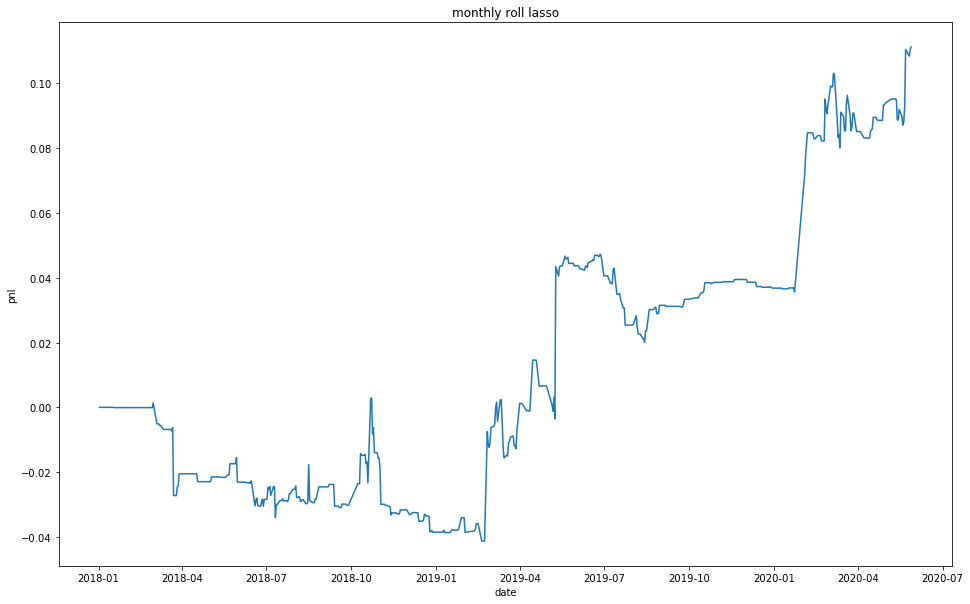

In [264]:
n_product = len(product_list[0:3])
save_path = "signal result atr"
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.lasso.4096"
start_month = 0
min_pnl = 10
min_num = 20
end_month = sum(month_len[0] < "2018")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[test_sample], all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe  0.7461707241443614  ## avg
## sharpe  1.4661086101373344 ## sharpe
## sharpe  1.739788502944618 ## risk parity
## sharpe  1.7661071787278613 ## diagonal risk parity
